In [24]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [25]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_csv('/content/drive/MyDrive/StockData/AAPL_stock_data.csv')
df = pd.read_csv('../Datasets/INTC Historical Data.csv')
df1=df.reset_index()['Price']

In [26]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [27]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]


In [28]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_val, yval = create_dataset(val_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)

In [30]:
#6. New

time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size-100]
X_test = X[train_size-100:train_size-100+test_size]
X_val = X[train_size-100+test_size:]

y_train = y[:train_size-100]
ytest = y[train_size-100:train_size-100+test_size]
yval = y[train_size+test_size-100:]

In [31]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [32]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [33]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


14/14 [==============================] - 6s 182ms/step - loss: 0.1390 - val_loss: 0.0119
Epoch 2/100
14/14 [==============================] - 2s 145ms/step - loss: 0.0161 - val_loss: 0.0180
Epoch 3/100
14/14 [==============================] - 2s 169ms/step - loss: 0.0091 - val_loss: 0.0102
Epoch 4/100
14/14 [==============================] - 2s 167ms/step - loss: 0.0069 - val_loss: 0.0086
Epoch 5/100
14/14 [==============================] - 2s 163ms/step - loss: 0.0058 - val_loss: 0.0067
Epoch 6/100
14/14 [==============================] - 2s 163ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 7/100
14/14 [==============================] - 2s 164ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 8/100
14/14 [==============================] - 2s 154ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 9/100
14/14 [==============================] - 2s 158ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 10/100
14/14 [==============================] - 2s 170ms/step - loss: 0.0046 - val_loss: 0.0043
E

In [34]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 31ms/step


In [35]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [36]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

In [37]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<30):
    
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.19407259]
101
1 day input [0.11016755 0.11911866 0.07482213 0.0700023  0.07711728 0.09570806
 0.12141382 0.12439752 0.08698646 0.09524902 0.07665825 0.06495295
 0.06655956 0.08377324 0.08583888 0.09065871 0.07574019 0.06219876
 0.02662382 0.0130824  0.01629562 0.00550838 0.         0.00068855
 0.00986918 0.02983704 0.03442736 0.02501721 0.01445949 0.0247877
 0.03534542 0.05324765 0.04705072 0.07137939 0.08056002 0.1211843
 0.11269222 0.0977737  0.0817076  0.07413358 0.09478999 0.10236401
 0.09823273 0.1007574  0.15193941 0.1650218  0.17833372 0.18338306
 0.18820289 0.18200597 0.18154694 0.17489098 0.17098921 0.16341519
 0.16593987 0.16043149 0.16616938 0.1590544  0.14344733 0.13679137
 0.12393849 0.10924948 0.09134726 0.09524902 0.1138398  0.14138168
 0.12393849 0.11177416 0.13197154 0.14551297 0.13977507 0.13472573
 0.11934818 0.11636447 0.09088823 0.09295387 0.1124627  0.09915079
 0.09111774 0.10970852 0.11544641 0.12347946 0.10580675 0.09410145
 0.05737893 0.09410145 0.1168235  0

1 day output [[0.20533577]]
2 day input [0.11911866 0.07482213 0.0700023  0.07711728 0.09570806 0.12141382
 0.12439752 0.08698646 0.09524902 0.07665825 0.06495295 0.06655956
 0.08377324 0.08583888 0.09065871 0.07574019 0.06219876 0.02662382
 0.0130824  0.01629562 0.00550838 0.         0.00068855 0.00986918
 0.02983704 0.03442736 0.02501721 0.01445949 0.0247877  0.03534542
 0.05324765 0.04705072 0.07137939 0.08056002 0.1211843  0.11269222
 0.0977737  0.0817076  0.07413358 0.09478999 0.10236401 0.09823273
 0.1007574  0.15193941 0.1650218  0.17833372 0.18338306 0.18820289
 0.18200597 0.18154694 0.17489098 0.17098921 0.16341519 0.16593987
 0.16043149 0.16616938 0.1590544  0.14344733 0.13679137 0.12393849
 0.10924948 0.09134726 0.09524902 0.1138398  0.14138168 0.12393849
 0.11177416 0.13197154 0.14551297 0.13977507 0.13472573 0.11934818
 0.11636447 0.09088823 0.09295387 0.1124627  0.09915079 0.09111774
 0.10970852 0.11544641 0.12347946 0.10580675 0.09410145 0.05737893
 0.09410145 0.1168235 

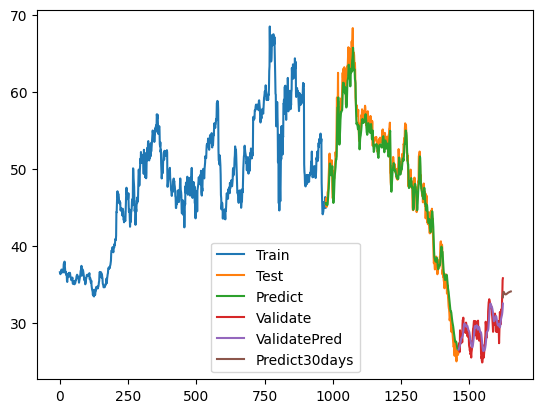

974 487 163


In [38]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

print(train_size, test_size, val_size)


In [39]:
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mse = mean_squared_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)
test_mape = mape(ytest, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
valid_mse = mean_squared_error(yval, y_pred_val)
valid_mae = mean_absolute_error(yval, y_pred_val)
valid_mape = mape(yval, y_pred_val)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
print("Validation MAPE:", valid_mape)


Testing RMSE: 48.99678545497416
Testing MAE: 48.23064239824537
Testing MAPE: 20491.296063286656
Validation RMSE: 29.144462678246867
Validation MAE: 29.103083326331557
Validation MAPE: inf


C:\Users\dangnghiepcuong\AppData\Local\Temp\ipykernel_3188\1210348153.py:3: RuntimeWarning:

divide by zero encountered in divide



In [40]:
print(scaler.inverse_transform(lst_output)[:10, 0])

[33.35574271 33.84647933 34.04300082 34.06238528 34.00278602 33.92247524
 33.84893931 33.79222659 33.75420818 33.73348432]


In [41]:
print(df['Price'].tail(10))

1614    31.31
1615    29.86
1616    30.96
1617    31.28
1618    31.82
1619    31.34
1620    33.07
1621    33.91
1622    35.58
1623    35.82
Name: Price, dtype: float64


In [42]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# pred_ind = list(range(len(df1), len(df1)+30))
# x_train_ind = list(range(0, train_size))
# x_test_ind = list(range(train_size, train_size+test_size))
# x_validation_ind = list(range(train_size+test_size, len(df1)))
# pred_ind = list(range(len(df1), len(df1)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=scaler.inverse_transform(test_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=scaler.inverse_transform(val_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Day', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'AMD LSTM data (6:3:1)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()